# 01 - Pandas and Data Wrangling

* Armand Boschin
* Cyril Wendl
* Francis Damachi

# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = './Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

import glob
import natsort
import pandas as pd
import numpy as np
from dateutil.parser import parse

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### Data field names
Column names and the names of the variables we want to extract slightly vary between countries. Hence, first we define the column names of the _date_ column, _variable_ and _national total_ columns as well as the names of the fields for each country.

In addition to new cases and total deaths, we also extract the data correponding to new deaths, total cases and total deaths summed over all couties to compare it to the national data. 

For new and total deaths and cases, respectively, we chose to extract confirmed values which seem most reliable.

In [2]:
# Dataframe importing 
# Colums: country, month, averagy, new cases, death

# column names and interesting variables for each country

# column name of the date column
col_date = {'guinea' : 'Date',
            'liberia': 'Date',
            'sl' : 'date'} 

# column name of the indicator variables to extract according to country
# column containing the variables
col_name={'guinea' : 'Description',
          'liberia': 'Variable',
          'sl' : 'variable'} 
# column containing national totals
col_total = {'guinea':'Totals',
             'liberia':'National',
             'sl': 'National'} # column name where the national totals per day are stored

# counties
col_counties={'guinea':['Conakry','Gueckedou','Macenta','Dabola','Kissidougou','Dinguiraye',
                        'Telimele','Boffa','Kouroussa','Siguiri','Pita','Nzerekore','Yomou',
                        'Dubreka','Forecariah','Kerouane','Coyah','Dalaba','Beyla','Kindia'],
              'liberia':['Bomi County','Bong County','Grand Kru','Lofa County','Margibi County',
                         'Maryland County','Montserrado County','Nimba County','River Gee County',
                         'RiverCess County','Sinoe County'],
              'sl':['Kailahun','Kenema','Kono','Kambia','Koinadugu','Bombali','Tonkolili','Port Loko',
                    'Pujehun','Bo','Moyamba','Bonthe','Western area urban','Western area rural']}


# rows names to extract according to country
# new deaths
var_death_new =  {'guinea' : ['New deaths registered today (confirmed)','New deaths registered'], 
                  # in the case of Guinea, the row names for new deaths differ
             'liberia': ['Newly reported deaths'],# 'Total death/s in confirmed cases'
             'sl':['etc_new_deaths']}

# total deaths
var_death_total =  {'guinea' : ['Total deaths of confirmed'],
             'liberia': ['Total death/s in confirmed cases'],# 'Total death/s in confirmed cases'
             'sl':['death_confirmed']}

# new cases
var_cases_new = {'guinea' : ['New cases of confirmed'],
             'liberia': ['New case/s (confirmed)'],
             'sl':['new_confirmed']}

# total cases
var_cases_tot = {'guinea' : ['Total cases of confirmed'],
             'liberia': ['Total confirmed cases'],
             'sl':['cum_confirmed']}


### Aggregate data frames
Now, we loop over all files and import them, applying necessary clean-up operations.

For each country and for each date, we extract the attributes explained above and clean them up (type conversions, comma stripping etc...). If there are `NaN` or missing values, they are reported as `NaN` values in the dataframe in order to keep track of the missing data. 

In the for loop, an array of dataframes `dfs` is produced, each dataframe consisting of one row containing the variables of interest for one given date and country, such as:

| Country   | Date         | New Cases   | New Deaths  | Total Cases   | Total Deaths |Total Deaths Counties  |
| --------- |:------------:| -----------:|------------:|--------------:|-------------:|----------------------:|
| Guinea    | 2014-08-26   | 10          | 5           | 490           | 292          |292                    |

All those DataFrames are in the list `dfs` and eventually merged in `df`, paying attention to the index.

In [3]:
dfs = [] # this is a list of dataframes (one for each day)
for c in ['guinea','liberia','sl']:
    for file in sorted(glob.glob(DATA_FOLDER+'/ebola/'+c+'_data/*.csv')): #going through all the files
        df = pd.read_csv(file,index_col=None)
        
        # Get Data
        columns=[col_date[c],col_name[c],col_total[c]]
        
        # Dates
        date = pd.to_datetime(df[1:2][col_date[c]]) # dates
        
        # New cases
        # Extract only relevant rows for new cases and relevant columns (date, name, total)
        df_cases_new = df[df[col_name[c]].isin(var_cases_new[c])][columns]
        if not pd.isnull(df_cases_new[col_total[c]].values).all(): 
            # Strip commas for 1000s
            df_cases_new[0:1][col_total[c]].values[0] = str(df_cases_new[0:1][col_total[c]].values[0]).replace(',','')
            # Convert to int (e.g., 10.0 or 10,0)
            df_cases_new[col_total[c]] = df_cases_new[col_total[c]].astype(int)
            # Getting the value 
            cases_new = int(df_cases_new[0:1][col_total[c]])
        else:
            cases_new = np.NaN
        
        # Total cases
        # Extract only relevant rows for total cases and relevant columns (date, name, total)
        df_cases_total = df[df[col_name[c]].isin(var_cases_tot[c])][columns]
        if not pd.isnull(df_cases_total[col_total[c]].values).all(): 
            # Strip commas for 1000s
            df_cases_total[0:1][col_total[c]].values[0] = str(df_cases_total[0:1][col_total[c]].values[0]).replace(',','')
            # Convert to int (e.g., 10.0 or 10,0)
            df_cases_total[col_total[c]] = df_cases_total[col_total[c]].astype(int)
            # Getting the value 
            cases_total = int(df_cases_total[0:1][col_total[c]])
        else: cases_total = np.NaN

        # New deaths
        # Extract only relevant rows for new deaths and relevant columns (date - name - total)
        df_deaths_new = df[df[col_name[c]].isin(var_death_new[c])][columns]
        if not pd.isnull(df_deaths_new[col_total[c]].values).all(): 
            # Getting the value 
            deaths_new = int(df_deaths_new[0:1][col_total[c]])
        else:
            deaths_new = np.NaN
        
        
        # Total Deaths
        # Extract only relevant rows for total deaths and relevant columns (date - name - total)
        df_deaths_total = df[df[col_name[c]].isin(var_death_total[c])][columns]
        if not pd.isnull(df_deaths_total[col_total[c]].values).all(): 
            # Getting the value 
            deaths_total = int(df_deaths_total[0:1][col_total[c]]) 
        else: 
            deaths_total = np.NaN
        
        
        # Total Deaths by County
        # Extract only relevant rows
        df_deaths_total_county_sum = df[df[col_name[c]].isin(var_death_total[c])] 
        cols=list(set(df.columns.values).difference(columns))
        # Extract only relevant columns (date - name - total)
        df_deaths_total_county_sum = df_deaths_total_county_sum[cols]
        for col in df_deaths_total_county_sum.columns:
            if not pd.isnull(df_deaths_total_county_sum[col]).all():
                df_deaths_total_county_sum[col]=df_deaths_total_county_sum[col].astype(int)
        deaths_total_county_sum = int(np.nansum(df_deaths_total_county_sum.values))
        
        # New dataframe from data (one row per date)
        df = pd.DataFrame({'Country':c,'Date':date,'New Cases':cases_new, 'Total Cases':cases_total,
                           'New Deaths':deaths_new, 'Total Deaths':deaths_total,
                           'Total Deaths Counties':deaths_total_county_sum},index=None)
        dfs.append(df)
        
for i in range(len(dfs)-1): # concatenate all dataframes (rows)
    dfs[0] = pd.concat([dfs[0],dfs[i+1]])
df=dfs[0]

df=df.sort_values(by=['Country','Date']) # sort by country and date
df=df.set_index(['Country','Date']) # new index
df.head()

New Cases  New Deaths  Total Cases  Total Deaths  \
Country Date                                                           
guinea  2014-08-04        4.0         2.0        351.0         228.0   
        2014-08-26       10.0         5.0        490.0         292.0   
        2014-08-27       10.0         2.0        499.0         294.0   
        2014-08-30        9.0         5.0        533.0         324.0   
        2014-08-31       29.0         3.0        563.0         337.0   

                    Total Deaths Counties  
Country Date                               
guinea  2014-08-04                    228  
        2014-08-26                    292  
        2014-08-27                    267  
        2014-08-30                    324  
        2014-08-31                    337

There seems to be a discrepancy between the new deaths (confirmed) and the total deaths (confirmed), as the new cases /deaths don't add up to the cumsum of the total cases / deaths of the next date. Maybe the data doesn't come from the same source or there is missing data. 

Also, the total deaths don't always quite add up with the sum of deaths per county, which may be due to incomplete data.

In [4]:
df.tail()

New Cases  New Deaths  Total Cases  Total Deaths  \
Country Date                                                           
sl      2014-12-01       72.0         NaN       5978.0        1549.0   
        2014-12-04       37.0         3.0       6238.0        1648.0   
        2014-12-05       54.0         8.0       6292.0        1669.0   
        2014-12-06        NaN         NaN       6317.0        1708.0   
        2014-12-13        NaN         NaN       6638.0           NaN   

                    Total Deaths Counties  
Country Date                               
sl      2014-12-01                   1549  
        2014-12-04                   1648  
        2014-12-05                   1669  
        2014-12-06                   1708  
        2014-12-13                      0

### Data checking

Let's check the data to see whether the index is unique and how many `NaN` values there are.

In [5]:
# Data checking
print('Index unique:')
print(df.index.is_unique) # True
for col in df.columns:
    print(col+':')
    print(df[df[col].isnull()].size) # get NaN colums (all 0)

Index unique:
True
New Cases:
115
New Deaths:
430
Total Cases:
125
Total Deaths:
250
Total Deaths Counties:
0


### Aggregate by month

Now, we can regroup the data by month and sums each column by the month. Then, we rename the date column as month column 

In [6]:
# Aggregate by month
def aggregate_month(df):
    df_month = pd.DataFrame(df.groupby([df.index.get_level_values(0),
                                        df.index.get_level_values(1).month]) # group by country and date index
                        .mean())
    df_month.index.names=['Country','Month']
    return df_month
    
df_month=aggregate_month(df)
df_month.round(2)

New Cases  New Deaths  Total Cases  Total Deaths  \
Country Month                                                     
guinea  8          12.40        3.40       487.20        295.00   
        9          13.00        3.56       767.69        451.06   
        10          6.00       15.00       977.00        562.00   
liberia 6           2.14        2.00        29.14         17.43   
        7           1.82        4.27        65.09         43.27   
        8           5.44       23.22       226.33        195.78   
        9           6.17       37.61       774.21        633.13   
        10          1.62       28.04      1599.31       1031.33   
        11          7.80       15.54      2709.93          0.00   
        12       2169.38         NaN      2825.67           NaN   
sl      8          20.61         NaN       864.72        326.50   
        9          36.96        2.67      1613.15        476.15   
        10         56.71        5.21      3076.75        905.46   
        11         66.21        2.40      4952.21       1241.11   
        12         54.33        5.50      6292.60       1643.50   

               Total Deaths Counties  
Country Month                         
guinea  8                     289.60  
        9                     440.19  
        10                    562.00  
liberia 6                      16.86  
        7                      43.27  
        8                     195.78  
        9                     606.75  
        10                    288.68  
        11                      0.00  
        12                      0.00  
sl      8                     331.15  
        9                     454.41  
        10                    911.14  
        11                    904.29  
        12                   1314.80

There is no data in December in Liberia and in August in Sierra Leone for the new deaths, causing `NaN` values (if there are only a few `NaN` values for a given month, the mean is calculated ignoring these values but if there are only `NaN` values, the mean cannot be computed and `NaN` is returned). 

The mean of new cases in December in Liberia seems huge. But when looking at the CSV files, it seems that there is a mistake in the way the data was recorded. The values entered in December as `New Cases` corresponds approximately to the `Total Cases` (around 3.000) of the other months and therefore the `New Cases` attribute in December cannot be considered reliable. That is why we have an outlier in December in Liberia.

In order to check the way we extract the Data (the columns we chose), we would like to count for each country and month the missing values, that is the number of `NaNs` that are omitted when we go through all the files.

### Number of NaN fields in each column

In [7]:
# More efficient: isnull() groupby month
df.isnull().groupby([df.index.get_level_values(0),df.index.get_level_values(1).month]).sum().astype(int)

New Cases  New Deaths  Total Cases  Total Deaths  \
Country Date                                                     
guinea  8             0           0            0             0   
        9             0           0            0             0   
        10            0           0            0             0   
liberia 6             0           0            0             0   
        7             0           0            0             0   
        8             0           0            0             0   
        9             0           1            0             1   
        10            4           0           12            19   
        11           10           2            1            14   
        12            1           9            6             9   
sl      8             2          20            2             2   
        9             2          26            2             2   
        10            0           9            0             0   
        11            2          16            2             2   
        12            2           3            0             1   

              Total Deaths Counties  
Country Date                         
guinea  8                         0  
        9                         0  
        10                        0  
liberia 6                         0  
        7                         0  
        8                         0  
        9                         0  
        10                        0  
        11                        0  
        12                        0  
sl      8                         0  
        9                         0  
        10                        0  
        11                        0  
        12                        0

Overall, the data seems quite reliable apart from the `New Deaths` count in Sierra Leone, which contains a lot of missing values.

## Detect outliers
Next, it seems like a good idea to automatically detect outliers and set wrong data to `NaN`. To do so, we can for instance show the values exceeding the 97th quantile (upper 3% of value range).

In [8]:
# for comparison
print(df.mean())

New Cases                 110.465347
New Deaths                 16.237410
Total Cases              1876.325000
Total Deaths              609.171429
Total Deaths Counties     462.511111
dtype: float64


In [9]:
outliers=df[df["New Cases"]>df["New Cases"].quantile(0.97)]
outliers=outliers.append(df[df["New Deaths"]>df["New Deaths"].quantile(0.97)])
outliers

New Cases  New Deaths  Total Cases  Total Deaths  \
Country Date                                                           
liberia 2014-12-04     2867.0         NaN          NaN           NaN   
        2014-12-05     2867.0         NaN          NaN           NaN   
        2014-12-06     2869.0         NaN          NaN           NaN   
        2014-12-07     2869.0         NaN          NaN           NaN   
        2014-12-08     2927.0         NaN          NaN           NaN   
        2014-12-09     2946.0         NaN          NaN           NaN   
sl      2014-11-08      111.0         1.0       4433.0        1133.0   
liberia 2014-09-11        0.0        53.0        790.0         584.0   
        2014-09-12        0.0        53.0        790.0         604.0   
        2014-09-16        4.0        54.0        847.0         659.0   
        2014-09-26        2.0        64.0        917.0         882.0   

                    Total Deaths Counties  
Country Date                               
liberia 2014-12-04                      0  
        2014-12-05                      0  
        2014-12-06                      0  
        2014-12-07                      0  
        2014-12-08                      0  
        2014-12-09                      0  
sl      2014-11-08                   1133  
liberia 2014-09-11                    584  
        2014-09-12                    604  
        2014-09-16                    659  
        2014-09-26                    882

The data in Liberia for 4-10th of December clearly seem erroneous and should be put to `NaN`.

In [10]:
for day in range(4,10):
    df.loc[('liberia','2014-12-'+str(day)),'New Cases']=np.NaN

df_month=aggregate_month(df)
df_month.round(2)

New Cases  New Deaths  Total Cases  Total Deaths  \
Country Month                                                     
guinea  8          12.40        3.40       487.20        295.00   
        9          13.00        3.56       767.69        451.06   
        10          6.00       15.00       977.00        562.00   
liberia 6           2.14        2.00        29.14         17.43   
        7           1.82        4.27        65.09         43.27   
        8           5.44       23.22       226.33        195.78   
        9           6.17       37.61       774.21        633.13   
        10          1.62       28.04      1599.31       1031.33   
        11          7.80       15.54      2709.93          0.00   
        12          5.00         NaN      2825.67           NaN   
sl      8          20.61         NaN       864.72        326.50   
        9          36.96        2.67      1613.15        476.15   
        10         56.71        5.21      3076.75        905.46   
        11         66.21        2.40      4952.21       1241.11   
        12         54.33        5.50      6292.60       1643.50   

               Total Deaths Counties  
Country Month                         
guinea  8                     289.60  
        9                     440.19  
        10                    562.00  
liberia 6                      16.86  
        7                      43.27  
        8                     195.78  
        9                     606.75  
        10                    288.68  
        11                      0.00  
        12                      0.00  
sl      8                     331.15  
        9                     454.41  
        10                    911.14  
        11                    904.29  
        12                   1314.80

It seems like Ebola peaked around October in Guinea, around September in Liberia and around October in Sierra Leone.

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

### DataFrame Merging
First we merge all data frames:

In [11]:
# Read in Excel files, concatenate them and add file name (MID1...9) for later merging
dfs=[]
for i in range(1,10):
    MID_tmp=pd.read_excel(DATA_FOLDER+'/microbiome/MID'+str(i)+'.xls', sheetname='Sheet 1', header=None,index_col=0)
    MID_tmp.columns=['Count']
    MID_tmp['BARCODE'] = 'MID'+str(i)  # add column with file name
    # new dataframe from data
    dfs.append(MID_tmp)
        
for i in range(len(dfs)-1): # concatenate all dataframes
    dfs[0] = pd.concat([dfs[0],dfs[i+1]])

MID=dfs[0]
MID.index.name='Species'
MID = MID.set_index('BARCODE',append=True)
MID = MID.reorder_levels(['BARCODE','Species'])
MID.head()

Count
BARCODE Species                                                  
MID1    Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      7
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      2
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...      3
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...      3
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...      7

### Metadata import and Merging
We can now import the metadata and merge the files.

In [12]:
# read metadata
metadata = pd.read_excel(DATA_FOLDER+'/microbiome/metadata.xls', sheetname='Sheet1', index_col=0)

# merge metadata and files
MID_merged = pd.merge(metadata, MID, left_index=True, right_index=True)#, on='BARCODE')
MID_merged=MID_merged.fillna('unknown')
MID_merged.head()

GROUP  \
BARCODE Species                                                                  
MID1    Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  EXTRACTION CONTROL   
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  EXTRACTION CONTROL   
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...  EXTRACTION CONTROL   
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...  EXTRACTION CONTROL   

                                                             SAMPLE  Count  
BARCODE Species                                                             
MID1    Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown      7  
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  unknown      2  
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...  unknown      3  
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...  unknown      3  
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...  unknown      7

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from IPython.core.display import HTML

In [14]:
HTML(filename=DATA_FOLDER + '/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


In [15]:
df = pd.read_excel(DATA_FOLDER + '/titanic.xls')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

#### Answer
* pclass: integers, values in {1, 2, 3} depending on the class. This is a `categorical` attribute.
* survived: integers, values in {0 ,1} depending on whether the person survived. This is a `categorical` attribute.
* name: string
* sex: string, values in {male, female}. This is a `categorical` attribute.
* age: double, values ranging from 0.1667 to 80.
* sibsp: integers, values from 0 to 8. This is a `categorical` attribute.
* parch: integers, values from 0 to 9. This is a `categorical` attribute.
* ticket: string (ticket number and name)
* fare: float, values rangins from 0 to 512.3292.
* cabin: string. This is a `categorical` attribute.
* embarked: char, values ins {C, Q, S}. This is a `categorical` attribute.
* boat: string (boat letter and number). This is a `categorical` attribute.
* body: integers: values from 1 to 328.
* home.dest: string. This is a `categorical` attribute.

Transforming `categorical` attributes:

In [16]:
df.rename(columns={'home.dest' : 'homedest'}, inplace=True)

In [17]:
df.pclass = df.pclass.astype('category')
df.survived = df.survived.astype('category')
df.sex = df.sex.astype('category')
df.sibsp = df.sibsp.astype('category')
df.parch = df.parch.astype('category')
df.cabin = df.cabin.astype('category')
df.embarked = df.embarked.astype('category')
df.boat = df.boat.astype('category')
df.homedest = df.homedest.astype('category')

In [18]:
# Categorical attribute values
print(df.columns)
for cat_col in ('pclass', 'survived', 'sex', 'sibsp', 'parch', 'cabin', 'embarked', 'boat', 'homedest'):
    print('===================')
    print(cat_col, ':', pd.unique(df[cat_col]))
    print(len(pd.unique(df[cat_col])), ' distinct values')

df.describe()

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'homedest'],
      dtype='object')
pclass : [1, 2, 3]
Categories (3, int64): [1, 2, 3]
3  distinct values
survived : [1, 0]
Categories (2, int64): [1, 0]
2  distinct values
sex : [female, male]
Categories (2, object): [female, male]
2  distinct values
sibsp : [0, 1, 2, 3, 4, 5, 8]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 8]
7  distinct values
parch : [0, 2, 1, 4, 3, 5, 6, 9]
Categories (8, int64): [0, 2, 1, 4, 3, 5, 6, 9]
8  distinct values
cabin : [B5, C22 C26, E12, D7, A36, ..., E121, F E69, E10, G6, F38]
Length: 187
Categories (186, object): [B5, C22 C26, E12, D7, ..., F E69, E10, G6, F38]
187  distinct values
embarked : [S, C, NaN, Q]
Categories (3, object): [S, C, Q]
4  distinct values
boat : [2, 11, NaN, 3, 10, ..., 16, 13 15 B, C D, 15 16, 13 15]
Length: 29
Categories (28, object): [2, 11, 3, 10, ..., 13 15 B, C D, 15 16, 13 15]
29  distinct values


,age,fare,body
count,1046.000000,1308.000000,121.000000
mean,29.881135,33.295479,160.809917
std,14.413500,51.758668,97.696922
min,0.166700,0.000000,1.000000
25%,21.000000,7.895800,72.000000
50%,28.000000,14.454200,155.000000
75%,39.000000,31.275000,256.000000
max,80.000000,512.329200,328.000000


### Question 3.2
Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

In [19]:
def plot_histogram(x, y, title, abscissa, figsize=(20,10)):
    """
    This functions plots a histogram adding the values on top of the bins.

    x: values of the attribute that is being counted
    y: counts of the x values
    title: title to give to the histogram
    abscissa: absissa to be displayed (what is being counted)
    """
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.5 # the width of the bars
    ind = np.arange(len(y))  # the x locations for the groups
    ax.bar(ind, y, width, color="red")
    ax.set_xticks(ind)
    ax.set_xticklabels(x, minor=False)
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel(abscissa)
    for i, v in enumerate(y):
        ax.text(i-width/6, v + 10, str(v), color='red')
    plt.show()

In [20]:
def handle_null(x, y, attribute):
    """
    This functions looks in the DataFrame is the `attribute` has some nan values and if so
    appends the counts to y and adds the 'Unknown' string to x.
    
    x: values of the attribute (that are being counted in the original DataFrame)
    y: counts of the values
    """
    tmp = df[attribute].isnull().value_counts()
    if len(tmp) == 2:
        x.append('Unknown')
        y.append(tmp[True])

#### Plot for the travel class:

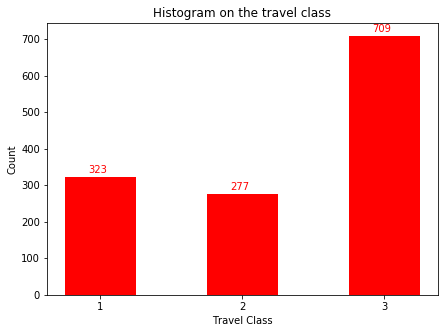

In [21]:
pclass_x = list(df['pclass'].value_counts().sort_index().index)
pclass_y = list(df['pclass'].value_counts().sort_index().values)
handle_null(pclass_x, pclass_y, 'pclass')

plot_histogram(pclass_x, pclass_y, 'Histogram on the travel class', 'Travel Class', figsize=(7,5))

#### Plot for the embarkation port:

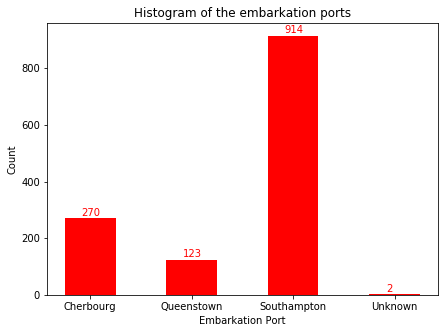

In [22]:
embarked_x = list(df['embarked'].value_counts().sort_index().index)
embarked_y = list(df['embarked'].value_counts().sort_index().values)
handle_null(embarked_x, embarked_y, 'embarked')

for n,i in enumerate(embarked_x):
    if i == 'S':
        embarked_x[n] = 'Southampton'
    if i == 'Q':
        embarked_x[n] = 'Queenstown'
    if i == 'C':
        embarked_x[n] = 'Cherbourg'

plot_histogram(embarked_x, embarked_y, 'Histogram of the embarkation ports', 'Embarkation Port', figsize=(7,5))

#### Plot for the gender:

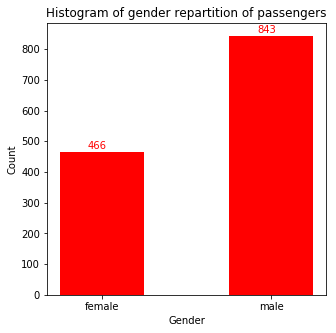

In [23]:
sex_x = list(df['sex'].value_counts().sort_index().index)
sex_y = list(df['sex'].value_counts().sort_index().values)
handle_null(sex_x, sex_y, 'sex')

plot_histogram(sex_x, sex_y, 'Histogram of gender repartition of passengers', 'Gender', figsize=(5,5))

#### Plot for the age

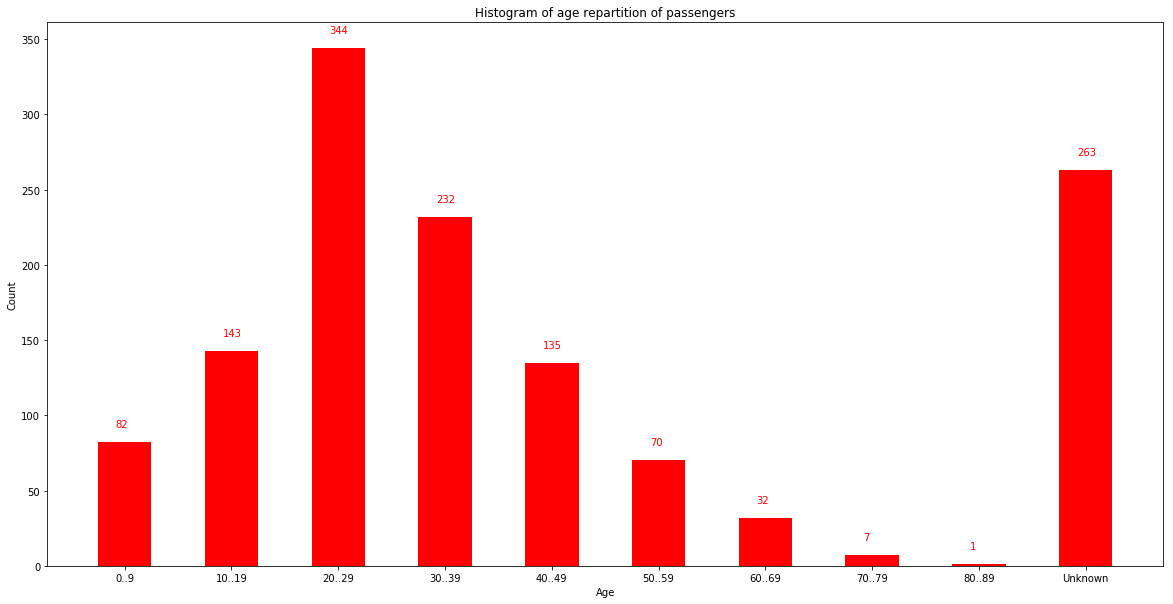

In [24]:
age_x = [u'0..9', u'10..19', u'20..29',u'30..39', u'40..49', u'50..59', u'60..69', u'70..79', u'80..89', u'Unknown']
age_y = [0 for i in range(10)]
for i in df['age'].index:
    if pd.isnull(df['age'][i]):
        age_y[9] += 1
    else:
        age_y[int(df['age'][i])//10] += 1

plot_histogram(age_x, age_y, 'Histogram of age repartition of passengers', 'Age')

### Question 3.3
_Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*._

#### Answer:

We want to go through the DataFrame in order to fill the floor_count DataFrame. The latter counts the number of passengers that have a cabin on each floor (A, B, C, D, E, F, G, T (Tank Top)) to get something like that: 
<img src='imgs/2.png' style="width: 100px;">

There are some passengers with several cabins. In that case we have to make sure that all the passenger's cabins are on the same floor. The list `problems` is meant to tackle this issue. It shows that the passengers that have cabins on different floors have cabins of the form:

['F G63', 'F G63', 'F E57', 'F E46', 'F G73', 'F E69', 'F G73']

We decide to ignore the cabin designation `F` as it seems to refer only to a floor and not really to a cabin.

In [25]:
problems = [] # this will contain the entries that have cabins on different floors.
floor_count = pd.DataFrame([0, 0, 0, 0, 0, 0, 0, 0, 0], columns=['count'], index=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Unknown'])

for i in df.index: #let's go through the dataframe looking at the cabin of each passenger
    cabin = df.loc[i, 'cabin']
    
    if pd.isnull(cabin):
        floor_count.loc['Unknown', 'count'] += 1
    
    if not pd.isnull(cabin): # then we know the cabin of the passenger
        tmp = cabin.split(' ')
        
        if len(tmp) == 1:
            floor_count.loc[tmp[0][0], 'count'] += 1

        if len(tmp) > 1:
            # then the passenger has several cabins
            # we have to check if they are all on the same floor
            boo = True
            for i in range(len(tmp)-1):
                if tmp[0][0] != tmp[i+1][0]:
                    boo = False
                    break
            if boo: # all cabins are on the same floor 
                floor_count.loc[tmp[0][0], 'count'] += 1
            if not boo:
                problems.append(cabin)
                floor_count.loc[tmp[1][0], 'count'] += 1 # this is explained under the celle (we choose to ignore 'F')

print(problems)

['F G63', 'F G63', 'F E57', 'F E46', 'F G73', 'F E69', 'F G73']


#### Plots

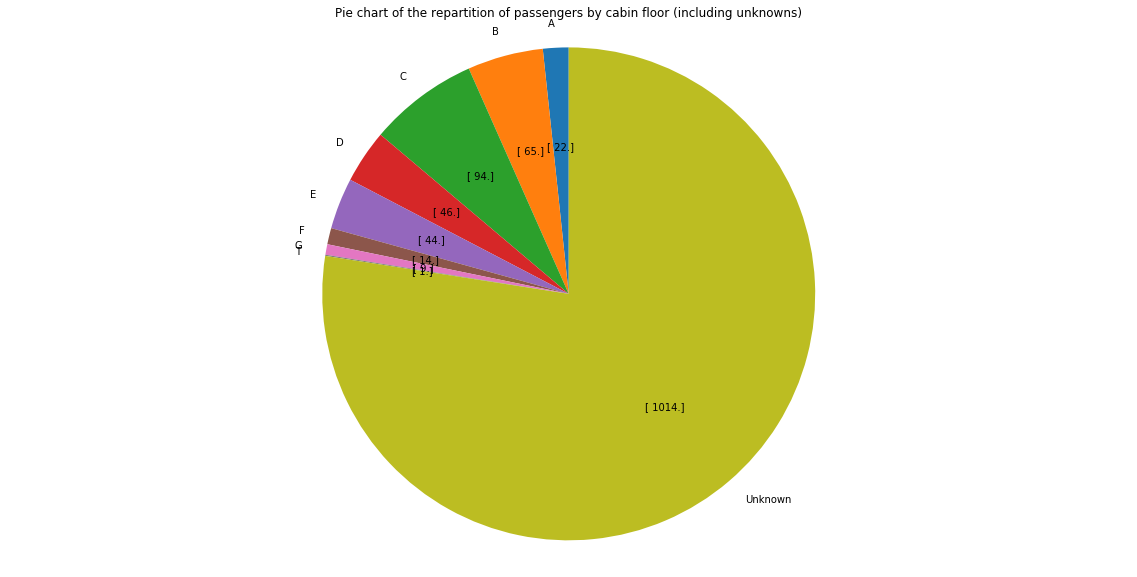

In [26]:
labels = 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Unknown'
sizes = np.array(floor_count.values)

def absolute_value(val):
    a  = np.round(val/100.*sizes.sum(), 0)
    return a

fig1, ax1 = plt.subplots(figsize=(20,10))
ax1.pie(sizes, labels=labels, autopct=absolute_value,
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie chart of the repartition of passengers by cabin floor (including unknowns)')
plt.show()

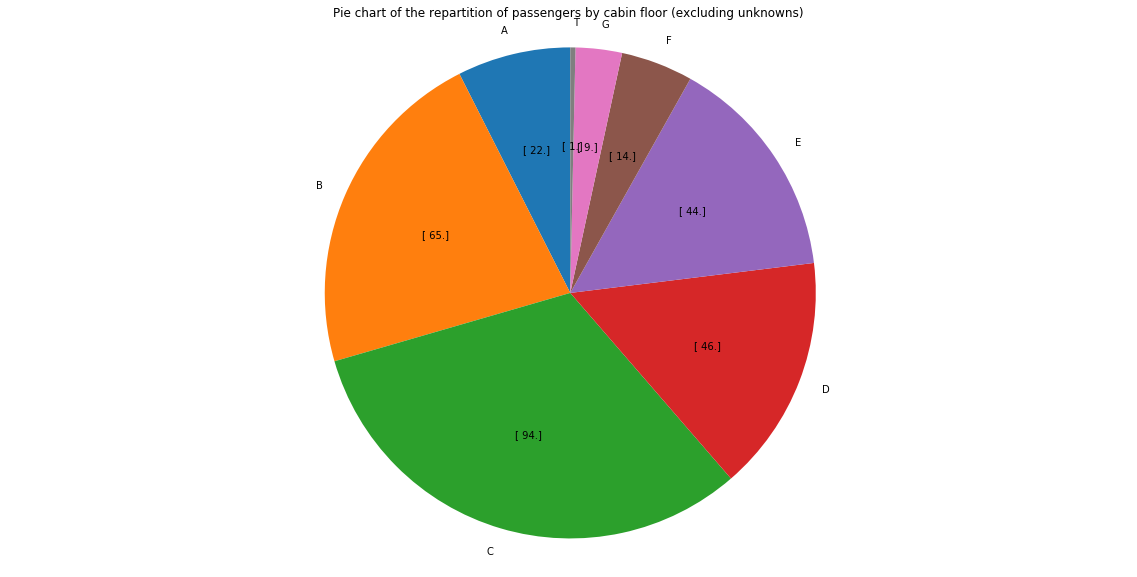

In [27]:
labels = 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'
sizes = np.array(floor_count.values[:-1])

def absolute_value(val):
    a  = np.round(val/100.*sizes.sum(), 0)
    return a

fig1, ax1 = plt.subplots(figsize=(20,10))
ax1.pie(sizes, labels=labels, shadow=False, autopct=absolute_value, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie chart of the repartition of passengers by cabin floor (excluding unknowns)')
plt.show()

### Question 3.4
_For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*._

#### Answer:
There are no NAs for the attribute `survived` so we do not have to worry about it in this question.

In [28]:
# survivors_count contains for each class the number of passengers that survived and those did not. 
# NAs are excluded of the count.
survival_count = pd.DataFrame(df['name'].groupby([df.pclass, df.survived]).count())
survival_count.columns = ['count']

# survivors_percentage contains for each class the percentage of passengers that survived or not.
# NAs are excluded.
survival_percentages = pd.DataFrame(df['name'].groupby(df.pclass).count())
survival_percentages.columns = ['pclass_total']
survival_percentages = pd.merge(survival_count, survival_percentages, left_index=True, right_index=True)
survival_percentages['percentage'] = np.divide(survival_percentages['count'], survival_percentages['pclass_total'])

survival_percentages

count  pclass_total  percentage
pclass survived                                 
1      0           123           323    0.380805
       1           200           323    0.619195
2      0           158           277    0.570397
       1           119           277    0.429603
3      0           528           709    0.744711
       1           181           709    0.255289

#### Figures

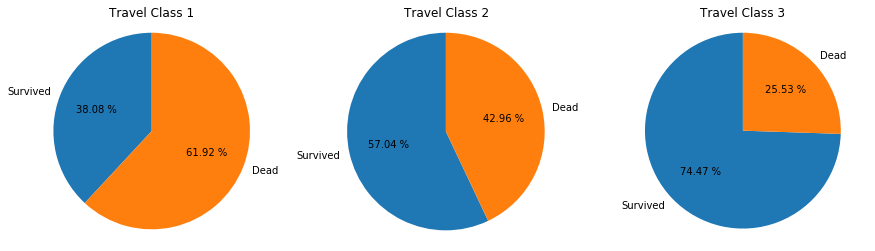

In [29]:
labels = 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'
sizes = np.array(floor_count.values[:-1])

plt.subplots(figsize=(15,4))

def percent(val):
    a  = str(val.round(2)) + " %"
    return a

for i in range(1,4):
    data_pie = survival_percentages[survival_percentages.index.labels[0]==(i-1)]
    y = data_pie['percentage'].values
    x = 'Survived', 'Dead'
    plt.subplot(1,3,i)
    plt.pie(y, labels=x, autopct=percent, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Travel Class '+ str(i))

plt.show()

### Question 3.5
_Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*._


#### Answer:
There are still no NAs for the attribute `survived` so we do not have to worry about it in this question.

In [30]:
# aggregate by pclass, sex, survived (count)
total_class_survived = pd.DataFrame(df.groupby([df.pclass, df.sex, df.survived]).agg({'name': 'count'}))

# calculate percentage grouped by [plcass, sex]
total_class = total_class_survived.groupby(level=[0,1]).apply(lambda x:
                                                 100 * x / float(x.sum()))
total_class.columns = ['percentage']
total_class_survived
total_class

percentage
pclass sex    survived            
1      female 0           3.472222
              1          96.527778
       male   0          65.921788
              1          34.078212
2      female 0          11.320755
              1          88.679245
       male   0          85.380117
              1          14.619883
3      female 0          50.925926
              1          49.074074
       male   0          84.787018
              1          15.212982

Now, we can get an array of 4\*3 containing the percentages for survived / dead women and men, respectively.

`survived_dead[0][i]` contains the percentage of women of class i who died

`survived_dead[1][i]` contains the percentage of women of class i who survived

`survived_dead[2][i]` contains the percentage of men of class i who died

`survived_dead[3][i]` contains the percentage of men of class i who survived

In [31]:
survived_dead = [] #4*3 array
for sex in range(0,2):
    for survived in range(0,2):
        tmp = total_class[total_class.index.labels[2] == sex] # filter by survived 
        tmp = tmp[tmp.index.labels[1] == survived] # filter by sex
        survived_dead.append(tmp['percentage'].values/100)

survived_dead

[array([ 0.03472222,  0.11320755,  0.50925926]),
 array([ 0.65921788,  0.85380117,  0.84787018]),
 array([ 0.96527778,  0.88679245,  0.49074074]),
 array([ 0.34078212,  0.14619883,  0.15212982])]

#### Plot histogram
We want to plot a hitogram grouped by pclass, always showing survived / dead for m / f 

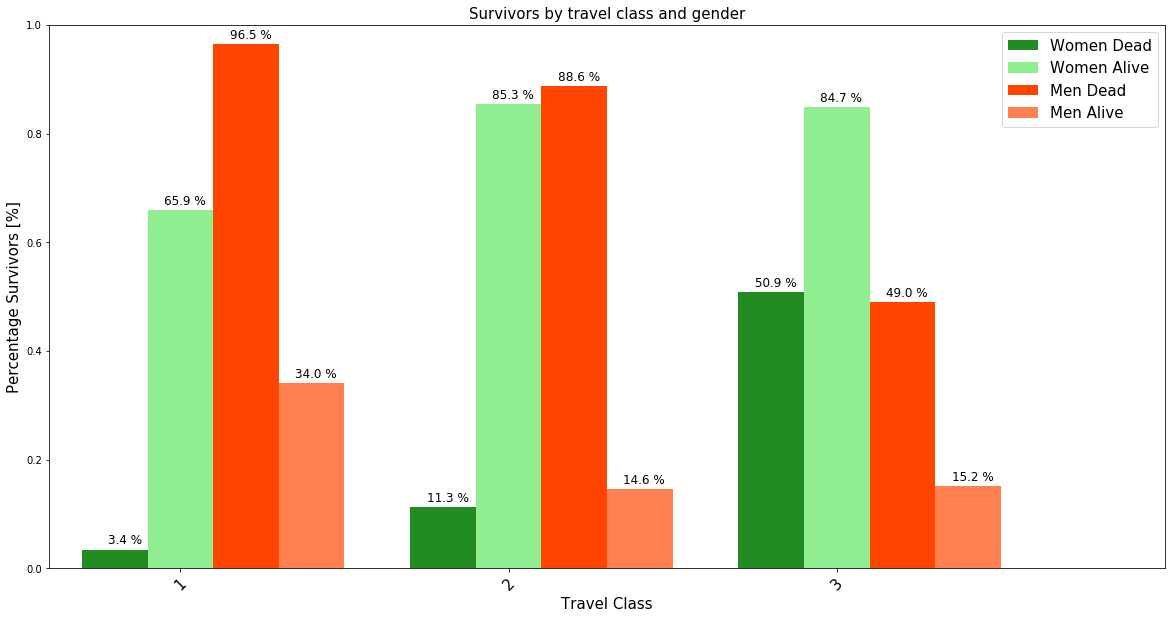

In [32]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# box positions
N = 3
ind = np.arange(N) # x locations for the groups
width = .2 # the width of the bars

dx=ind
rects=[] # dead_women, living_women, dead_men, living_men

color_map = [colors['forestgreen'], colors['lightgreen'], colors['orangered'], colors['coral']]

for e in range(1,5):
    rects.append(ax.bar(dx, survived_dead[e-1], width,color=color_map[e-1]))
    dx=ind+(e)*width
    
# bars
fsize=15
# axes and labels
ax.set_xlim(-width, len(ind) + width)
ax.set_ylim(0,1)
ax.set_xlabel('Travel Class', fontsize=fsize)
ax.set_ylabel('Percentage Survivors [%]', fontsize=fsize)
ax.set_title('Survivors by travel class and gender', fontsize=fsize)
xTickMarks = [str(i) for i in range(1,4)]
ax.set_xticks(ind + width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=fsize)

# add the value on each bar
ax.text(0-0.02, survived_dead[0][0] +0.01, str(int(survived_dead[0][0]*1000)/10)+' %', color='black', fontsize=12)
ax.text(1-0.05, survived_dead[0][1] +0.01, str(int(survived_dead[0][1]*1000)/10)+' %', color='black', fontsize=12)
ax.text(2-0.05, survived_dead[0][2] +0.01, str(int(survived_dead[0][2]*1000)/10)+' %', color='black', fontsize=12)
ax.text(0+0.15, survived_dead[1][0] +0.01, str(int(survived_dead[1][0]*1000)/10)+' %', color='black', fontsize=12)
ax.text(1+0.15, survived_dead[1][1] +0.01, str(int(survived_dead[1][1]*1000)/10)+' %', color='black', fontsize=12)
ax.text(2+0.15, survived_dead[1][2] +0.01, str(int(survived_dead[1][2]*1000)/10)+' %', color='black', fontsize=12)
ax.text(0+0.35, survived_dead[2][0] +0.01, str(int(survived_dead[2][0]*1000)/10)+' %', color='black', fontsize=12)
ax.text(1+0.35, survived_dead[2][1] +0.01, str(int(survived_dead[2][1]*1000)/10)+' %', color='black', fontsize=12)
ax.text(2+0.35, survived_dead[2][2] +0.01, str(int(survived_dead[2][2]*1000)/10)+' %', color='black', fontsize=12)
ax.text(0+0.55, survived_dead[3][0] +0.01, str(int(survived_dead[3][0]*1000)/10)+' %', color='black', fontsize=12)
ax.text(1+0.55, survived_dead[3][1] +0.01, str(int(survived_dead[3][1]*1000)/10)+' %', color='black', fontsize=12)
ax.text(2+0.55, survived_dead[3][2] +0.01, str(int(survived_dead[3][2]*1000)/10)+' %', color='black', fontsize=12)

## add a legend
ax.legend(('Women Dead', 'Women Alive','Men Dead', 'Men Alive'), fontsize=fsize)

plt.show()

### Question 3.6 
_Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index._

In [33]:
# Create two labels, based on age
df_sorted = df[df.age.notnull()].sort_values(by='age')
df_sorted['cat'] = pd.cut(df_sorted['age'].values, 2, labels=['young', 'old'])

In [34]:
# get the data ready
total_class_survived = pd.DataFrame(df_sorted.groupby([df_sorted.pclass, df_sorted.sex,
                                                       df_sorted.survived, df_sorted.cat]).agg({'cat': 'count'}))
total_class_survived.columns = ['count']
total_class_survived.index.rename(['Travel Class','Sex','Survived','Age Category'],inplace=True)

total_class_survived = total_class_survived.reorder_levels(['Age Category', 'Travel Class', 'Sex', 'Survived'])
total_class_survived.sort_index(level=[1,2],inplace=True)
total_class_survived.head()

count
Age Category Travel Class Sex    Survived       
young        1            female 0             3
                                 1            80
old          1            female 0             2
                                 1            48
young        1            male   0            40

In [36]:
# get the percentage of survivors for as count / sum of counts for a given age category, travel class and sex
total_class = total_class_survived.groupby(level=[0,1,2]).apply(lambda x:
                                                 100 * x / float(x.sum()))
total_class.columns = ["percentage"]

In [37]:
total_class

percentage
Age Category Travel Class Sex    Survived            
young        1            female 0           3.614458
                                 1          96.385542
old          1            female 0           4.000000
                                 1          96.000000
young        1            male   0          55.555556
                                 1          44.444444
old          1            male   0          73.417722
                                 1          26.582278
young        2            female 0           9.195402
                                 1          90.804598
old          2            female 0          18.750000
                                 1          81.250000
young        2            male   0          83.064516
                                 1          16.935484
old          2            male   0          94.117647
                                 1           5.882353
young        3            female 0          51.428571
                                 1          48.571429
old          3            female 0          66.666667
                                 1          33.333333
young        3            male   0          81.789137
                                 1          18.210863
old          3            male   0          94.444444
                                 1           5.555556